# <span style='font-family:"Times New Roman"'> <span styel=''>**TP53 LOSS SIZE COMPARAISON**

*Emile Cohen*
    
*June 2020*

**Goal:** In this notebook, we will compare the cn_length of our different LOSS groups (*0_HETLOSS* and *>=1_LOSS*) to see if there is a size effect that could explain the Genome Instability difference between *0_HETLOSS* and *1_WILD_TYPE*, 2 mono-allelic subgroups.

---

In [46]:
%run -i '../../utils/setup_environment.ipy'

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import fisher_exact, ranksums, chi2, norm
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.gridspec as gridspec
import pickle

data_path = '../../data/'
data_wgd = data_path + 'impact-facets-tp53/processed/wgd/'
data_no_wgd = data_path + 'impact-facets-tp53/processed/no_wgd/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

In [44]:
def boxplot_sampletype(df: pd.DataFrame, group:str, palette, order, metrics: str, figsize= (10,3), title: str = '', title_font: int=12, xlim=[0,1]):
    fig=plt.figure(figsize=figsize)
    ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
    
    sns.boxplot(y=metrics, x=group,data=df,ax=ax, dodge=False,order=order, palette=palette).set_title(title, weight='bold', fontsize=title_font, y=1.1)

    style(ax)
    ax.set_ylim(xlim)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    return fig, ax

def style(ax1):
    for i, artist in enumerate(ax1.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i * 6, i * 6 + 6):
            line = ax1.lines[j]
            if j % 6 == 4: line.set_color('black')
            else: line.set_color(col)
            line.set_mfc('None')
            line.set_mec('None')



In [75]:
master = non_wgd_load_and_cut(data_path + 'impact-facets-tp53/processed/no_wgd/master_no_wgd.pkl')
gene_level = pd.read_csv(data_no_wgd + 'gene_level_nowgd.txt', sep='\t').drop('Unnamed: 0', axis=1)
arm_level = pd.read_csv(data_no_wgd + 'arm_level_nowgd.txt', sep='\t').drop('Unnamed: 0', axis=1)
gene_level_tp53 = gene_level[gene_level['gene'] == 'TP53']

In [91]:
master_0_HETLOSS = master[master['tp53_group'] == '0_HETLOSS']['Sample_Id'].tolist()
master_1_LOSS = master[master['tp53_group'] == '>=1_LOSS']['Sample_Id'].tolist()

def get_group(x):
    if x['sample'] in master_0_HETLOSS:
        return '0_HETLOSS'
    elif x['sample'] in master_1_LOSS:
        return '>=1_LOSS'
    
gene_level_tp53['group'] = gene_level_tp53.apply(get_group, axis=1)

In [71]:
seg_0_HETLOSS = gene_level_tp53[gene_level_tp53['sample'].isin(master_0_HETLOSS)]['seg_length']#.tolist()
seg_1_LOSS = gene_level_tp53[gene_level_tp53['sample'].isin(master_1_LOSS)]['seg_length']#.tolist()
total_seg = gene_level_tp53['seg_length']

# CN Segment Length in both groups

In [68]:
seg_0_HETLOSS.describe()

count    2.431000e+03
mean     2.359663e+07
std      1.695051e+07
min      1.110200e+04
25%      1.592795e+07
50%      2.137560e+07
75%      2.523688e+07
max      8.069330e+07
Name: seg_length, dtype: float64

In [69]:
seg_1_LOSS.describe()

count    3.465000e+03
mean     2.680201e+07
std      1.878964e+07
min      1.105200e+04
25%      1.701683e+07
50%      2.142978e+07
75%      2.898210e+07
max      8.069331e+07
Name: seg_length, dtype: float64

(<Figure size 400x1000 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1361efa90>)

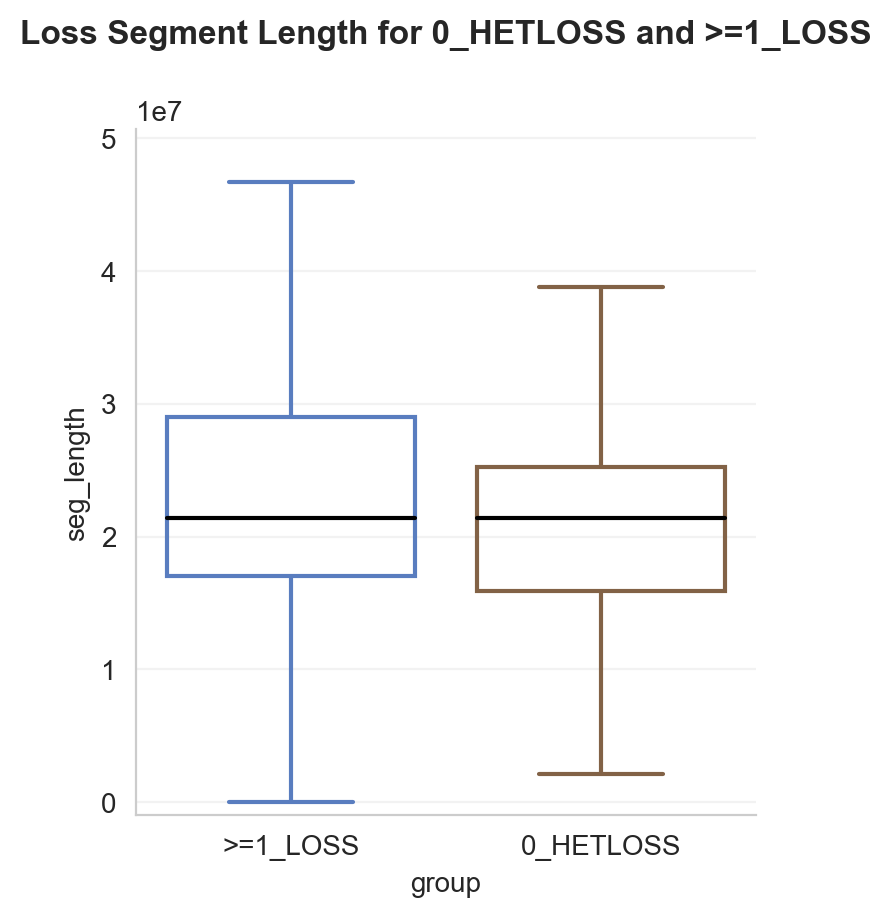

In [60]:
boxplot_sampletype(df=gene_level_tp53[['seg_length', 'group']], 
                   group='group', 
                   palette=palette, 
                   order = ['>=1_LOSS', '0_HETLOSS'], 
                   metrics='seg_length', 
                   figsize= (4,10), 
                   title= 'Loss Segment Length for 0_HETLOSS and >=1_LOSS', 
                   title_font=12, 
                   xlim=[-1000000,50693314])

* 0_HETLOSS < >=1_LOSS in terms of median of Loss seg_length which is not what we expected
* There are very few cases where seg_length=80Mb, so very few full 17 loss which is weird ...

# 17p/17q LOSS proportion
We want to compute the proportion of samples having a 17p LOSS and those having a 17p + 17q LOSS in arm_level file so that we can have the overall numbers and compare to the gen level file seg_length as a sanity check.

In [87]:
arm_level_het = arm_level[arm_level['sample'].isin(master_0_HETLOSS)]
arm_level_loss = arm_level[arm_level['sample'].isin(master_1_LOSS)]

In [92]:
gene_level_tp53_loss = gene_level_tp53[gene_level_tp53['group'].isin(['0_HETLOSS', '>=1_LOSS'])]

In [109]:
def get_17_LOSS(x):
    sample_id = x['sample']
    arm_level_samp = arm_level[arm_level['sample'] == sample_id][arm_level['arm'].isin(['17p', '17q'])]
    try:
        sev_p = arm_level_samp[arm_level_samp['arm'] == '17p']['cn_state'].tolist()[0]
    except: 
        sev_p = '...'
        print('17p: ' + sample_id)
    
    try:
        sev_q = arm_level_samp[arm_level_samp['arm'] == '17q']['cn_state'].tolist()[0]
    except:
        sev_q = '...'
        print('17q: ' + sample_id)
        
    if sev_p == 'HETLOSS' and sev_q == 'HETLOSS':
        return '17'
    elif sev_p != 'HETLOSS' and sev_q != 'HETLOSS':
        return 'no_17'
    elif sev_p == 'HETLOSS' and sev_q != 'HETLOSS':
        return '17p'
    elif sev_p != 'HETLOSS' and sev_q == 'HETLOSS':
        return '17q'

gene_level_tp53_loss['17_state'] = gene_level_tp53_loss.apply(get_17_LOSS, axis=1)

17q: P-0025997-T01-IM6_P-0025997-N01-IM6
17q: P-0036570-T01-IM6_P-0036570-N01-IM6
17q: P-0000285-T01-IM3_P-0000285-N01-IM3
17q: P-0020739-T01-IM6_P-0020739-N01-IM6
17p: P-0017719-T01-IM6_P-0017719-N01-IM6
17q: P-0016335-T01-IM6_P-0016335-N01-IM6
17p: P-0032012-T01-IM6_P-0032012-N01-IM6
17q: P-0020585-T01-IM6_P-0020585-N01-IM6
17q: P-0017107-T01-IM6_P-0017107-N01-IM6
17p: P-0016888-T01-IM6_P-0016888-N01-IM6
17q: P-0030792-T01-IM6_P-0030792-N01-IM6
17q: P-0002705-T01-IM3_P-0002705-N01-IM3
17q: P-0020167-T01-IM6_P-0020167-N01-IM6
17q: P-0032547-T01-IM6_P-0032547-N01-IM6
17q: P-0014236-T01-IM6_P-0014236-N01-IM6
17q: P-0025264-T01-IM6_P-0025264-N01-IM6
17q: P-0004427-T01-IM5_P-0004427-N01-IM5
17p: P-0017317-T01-IM6_P-0017317-N01-IM6
17q: P-0035818-T01-IM6_P-0035818-N01-IM6
17p: P-0006220-T01-IM5_P-0006220-N01-IM5
17q: P-0015209-T01-IM6_P-0015209-N01-IM6
17q: P-0025651-T01-IM6_P-0025651-N01-IM6
17q: P-0021430-T01-IM6_P-0021430-N01-IM6
17p: P-0027627-T01-IM6_P-0027627-N01-IM6
17q: P-0035513-T

17q: P-0035843-T01-IM6_P-0035843-N01-IM6
17p: P-0000508-T02-IM6_P-0000508-N01-IM6
17q: P-0022085-T01-IM6_P-0022085-N01-IM6
17p: P-0006931-T01-IM5_P-0006931-N01-IM5
17q: P-0005205-T01-IM5_P-0005205-N01-IM5
17q: P-0010812-T01-IM5_P-0010812-N01-IM5
17p: P-0021563-T01-IM6_P-0021563-N01-IM6
17p: P-0009933-T01-IM5_P-0009933-N01-IM5
17q: P-0016045-T01-IM6_P-0016045-N01-IM6
17p: P-0004856-T01-IM5_P-0004856-N01-IM5
17q: P-0005713-T01-IM5_P-0005713-N01-IM5
17q: P-0015430-T01-IM6_P-0015430-N01-IM6
17q: P-0020405-T01-IM6_P-0020405-N01-IM6
17p: P-0010075-T01-IM5_P-0010075-N01-IM5
17p: P-0030358-T01-IM6_P-0030358-N01-IM6
17q: P-0030699-T01-IM6_P-0030699-N01-IM6
17q: P-0020411-T01-IM6_P-0020411-N01-IM6
17q: P-0015745-T01-IM6_P-0015745-N01-IM6
17q: P-0012409-T01-IM5_P-0012409-N01-IM5
17q: P-0005826-T01-IM5_P-0005826-N01-IM5
17q: P-0021476-T01-IM6_P-0021476-N01-IM6
17q: P-0003711-T01-IM5_P-0003711-N01-IM5
17q: P-0029920-T01-IM6_P-0029920-N01-IM6
17q: P-0020920-T01-IM6_P-0020920-N01-IM6
17q: P-0033420-T

17q: P-0035429-T01-IM6_P-0035429-N01-IM6
17q: P-0020727-T01-IM6_P-0020727-N01-IM6
17q: P-0009352-T01-IM5_P-0009352-N01-IM5
17q: P-0013500-T01-IM5_P-0013500-N01-IM5
17p: P-0011259-T01-IM5_P-0011259-N02-IM5
17q: P-0031695-T01-IM6_P-0031695-N01-IM6
17q: P-0024798-T01-IM6_P-0024798-N01-IM6
17p: P-0004411-T01-IM5_P-0004411-N01-IM5
17q: P-0004411-T01-IM5_P-0004411-N01-IM5
17q: P-0035914-T01-IM6_P-0035914-N01-IM6
17p: P-0027755-T01-IM6_P-0027755-N01-IM6
17q: P-0027755-T02-IM6_P-0027755-N01-IM6
17q: P-0022015-T01-IM6_P-0022015-N01-IM6
17p: P-0006072-T01-IM5_P-0006072-N01-IM5
17q: P-0006072-T01-IM5_P-0006072-N01-IM5
17q: P-0023953-T01-IM6_P-0023953-N01-IM6
17q: P-0024728-T01-IM6_P-0024728-N01-IM6
17q: P-0019952-T01-IM6_P-0019952-N01-IM6
17q: P-0025663-T01-IM6_P-0025663-N01-IM6
17q: P-0033643-T01-IM6_P-0033643-N01-IM6
17p: P-0009730-T01-IM5_P-0009730-N01-IM5
17p: P-0009161-T01-IM5_P-0009161-N01-IM5
17p: P-0013309-T01-IM5_P-0013309-N01-IM5
17q: P-0013309-T01-IM5_P-0013309-N01-IM5
17q: P-0005602-T

17q: P-0004101-T01-IM5_P-0004101-N01-IM5
17q: P-0026964-T01-IM6_P-0026964-N01-IM6
17p: P-0012026-T01-IM5_P-0012026-N01-IM5
17p: P-0004675-T01-IM5_P-0004675-N01-IM5
17q: P-0000247-T01-IM3_P-0000247-N01-IM3
17p: P-0025808-T01-IM6_P-0025808-N01-IM6
17q: P-0015575-T01-IM6_P-0015575-N01-IM6
17q: P-0023215-T01-IM6_P-0023215-N01-IM6
17p: P-0018414-T01-IM6_P-0018414-N01-IM6
17p: P-0005705-T01-IM5_P-0005705-N01-IM5
17q: P-0019033-T01-IM6_P-0019033-N01-IM6
17p: P-0017521-T01-IM6_P-0017521-N01-IM6
17q: P-0012398-T01-IM5_P-0012398-N01-IM5
17p: P-0013457-T01-IM5_P-0013457-N01-IM5
17p: P-0016197-T01-IM6_P-0016197-N01-IM6
17q: P-0010373-T01-IM5_P-0010373-N01-IM5
17p: P-0021695-T01-IM6_P-0021695-N01-IM6
17q: P-0021695-T01-IM6_P-0021695-N01-IM6
17q: P-0009330-T01-IM5_P-0009330-N01-IM5
17q: P-0024947-T01-IM6_P-0024947-N01-IM6
17p: P-0011278-T01-IM5_P-0011278-N01-IM5
17q: P-0004523-T01-IM5_P-0004523-N01-IM5
17q: P-0004929-T01-IM5_P-0004929-N01-IM5
17p: P-0022896-T01-IM6_P-0022896-N01-IM6
17p: P-0027820-T

17p: P-0014860-T01-IM6_P-0014860-N01-IM6
17q: P-0020322-T01-IM6_P-0020322-N01-IM6
17q: P-0017476-T01-IM6_P-0017476-N01-IM6
17q: P-0037544-T01-IM6_P-0037544-N01-IM6
17q: P-0017801-T01-IM6_P-0017801-N01-IM6
17q: P-0017801-T02-IM6_P-0017801-N01-IM6
17q: P-0031743-T01-IM6_P-0031743-N01-IM6
17q: P-0026428-T01-IM6_P-0026428-N01-IM6
17q: P-0020161-T01-IM6_P-0020161-N01-IM6
17p: P-0028292-T01-IM6_P-0028292-N01-IM6
17q: P-0033244-T01-IM6_P-0033244-N01-IM6
17q: P-0015852-T01-IM6_P-0015852-N01-IM6
17q: P-0003547-T01-IM5_P-0003547-N01-IM5
17q: P-0022502-T01-IM6_P-0022502-N01-IM6
17q: P-0003690-T01-IM5_P-0003690-N01-IM5
17q: P-0026731-T01-IM6_P-0026731-N01-IM6
17q: P-0023957-T01-IM6_P-0023957-N01-IM6
17p: P-0032379-T01-IM6_P-0032379-N01-IM6
17q: P-0032379-T01-IM6_P-0032379-N01-IM6
17q: P-0004548-T01-IM5_P-0004548-N01-IM5
17p: P-0022828-T01-IM6_P-0022828-N01-IM6
17q: P-0022828-T01-IM6_P-0022828-N01-IM6
17q: P-0004457-T01-IM5_P-0004457-N01-IM5
17p: P-0008434-T01-IM5_P-0008434-N01-IM5
17q: P-0002975-T

17q: P-0026613-T01-IM6_P-0026613-N01-IM6
17q: P-0001222-T01-IM3_P-0001222-N01-IM3
17q: P-0025483-T02-IM6_P-0025483-N01-IM6
17q: P-0014391-T01-IM6_P-0014391-N01-IM6
17q: P-0006556-T01-IM5_P-0006556-N01-IM5
17q: P-0008515-T01-IM5_P-0008515-N01-IM5
17q: P-0008515-T02-IM5_P-0008515-N01-IM5
17q: P-0031243-T01-IM6_P-0031243-N01-IM6
17q: P-0004789-T01-IM5_P-0004789-N01-IM5
17q: P-0023473-T01-IM6_P-0023473-N01-IM6
17q: P-0007521-T01-IM5_P-0007521-N01-IM5
17p: P-0021061-T01-IM6_P-0021061-N01-IM6
17q: P-0034217-T01-IM6_P-0034217-N01-IM6
17p: P-0012403-T01-IM5_P-0012403-N01-IM5
17q: P-0012403-T03-IM6_P-0012403-N01-IM6
17q: P-0037398-T01-IM6_P-0037398-N01-IM6
17p: P-0013530-T02-IM6_P-0013530-N01-IM6
17p: P-0002863-T01-IM3_P-0002863-N01-IM3
17q: P-0020085-T01-IM6_P-0020085-N01-IM6
17q: P-0016487-T01-IM6_P-0016487-N01-IM6
17p: P-0032573-T01-IM6_P-0032573-N01-IM6
17q: P-0016969-T02-IM6_P-0016969-N01-IM6
17p: P-0035283-T01-IM6_P-0035283-N01-IM6
17q: P-0035283-T01-IM6_P-0035283-N01-IM6
17p: P-0014505-T

17p: P-0012826-T01-IM5_P-0012826-N01-IM5
17q: P-0012826-T01-IM5_P-0012826-N01-IM5
17p: P-0032965-T01-IM6_P-0032965-N01-IM6
17q: P-0004753-T01-IM5_P-0004753-N01-IM5
17q: P-0037452-T01-IM6_P-0037452-N01-IM6
17p: P-0024140-T01-IM6_P-0024140-N01-IM6
17p: P-0027975-T02-IM6_P-0027975-N01-IM6
17p: P-0007988-T01-IM5_P-0007988-N01-IM5
17q: P-0007988-T01-IM5_P-0007988-N01-IM5
17q: P-0028502-T01-IM6_P-0028502-N01-IM6
17q: P-0016179-T01-IM6_P-0016179-N01-IM6
17q: P-0035382-T01-IM6_P-0035382-N01-IM6
17q: P-0003821-T01-IM5_P-0003821-N01-IM5
17p: P-0010253-T01-IM5_P-0010253-N01-IM5
17q: P-0019474-T01-IM6_P-0019474-N01-IM6
17q: P-0036702-T01-IM6_P-0036702-N01-IM6
17q: P-0029405-T01-IM6_P-0029405-N01-IM6
17q: P-0002417-T01-IM3_P-0002417-N01-IM3
17q: P-0002417-T02-IM5_P-0002417-N01-IM5
17p: P-0006702-T01-IM5_P-0006702-N01-IM5
17p: P-0002952-T01-IM3_P-0002952-N01-IM3
17q: P-0024631-T01-IM6_P-0024631-N02-IM6
17q: P-0024631-T02-IM6_P-0024631-N02-IM6
17q: P-0024631-T03-IM6_P-0024631-N02-IM6
17p: P-0015328-T

17p: P-0006053-T01-IM5_P-0006053-N01-IM5
17p: P-0000964-T03-IM5_P-0000964-N01-IM5
17p: P-0017892-T01-IM6_P-0017892-N01-IM6
17p: P-0023851-T02-IM6_P-0023851-N01-IM6
17q: P-0035445-T01-IM6_P-0035445-N01-IM6
17p: P-0005524-T03-IM5_P-0005524-N01-IM5
17q: P-0005524-T03-IM5_P-0005524-N01-IM5
17q: P-0010372-T01-IM5_P-0010372-N01-IM5
17q: P-0009270-T01-IM5_P-0009270-N01-IM5
17p: P-0020974-T01-IM6_P-0020974-N01-IM6
17q: P-0023794-T01-IM6_P-0023794-N01-IM6
17q: P-0015436-T01-IM6_P-0015436-N01-IM6
17p: P-0030645-T01-IM6_P-0030645-N01-IM6
17q: P-0023789-T01-IM6_P-0023789-N01-IM6
17q: P-0028570-T02-IM6_P-0028570-N01-IM6
17p: P-0008877-T01-IM5_P-0008877-N01-IM5
17q: P-0014384-T01-IM6_P-0014384-N01-IM6
17q: P-0014384-T02-IM6_P-0014384-N01-IM6
17q: P-0036457-T01-IM6_P-0036457-N01-IM6
17p: P-0008907-T01-IM5_P-0008907-N01-IM5
17q: P-0014477-T01-IM6_P-0014477-N01-IM6
17q: P-0014477-T02-IM6_P-0014477-N01-IM6
17q: P-0020865-T01-IM6_P-0020865-N01-IM6
17q: P-0032871-T01-IM6_P-0032871-N01-IM6
17p: P-0007183-T

17q: P-0003913-T01-IM3_P-0003913-N01-IM3
17q: P-0004764-T01-IM5_P-0004764-N01-IM5
17q: P-0004850-T01-IM5_P-0004850-N01-IM5
17q: P-0004851-T01-IM5_P-0004851-N01-IM5
17p: P-0004903-T01-IM5_P-0004903-N01-IM5
17p: P-0005020-T01-IM5_P-0005020-N01-IM5
17q: P-0005207-T01-IM5_P-0005207-N01-IM5
17p: P-0005849-T01-IM5_P-0005849-N01-IM5
17q: P-0005849-T01-IM5_P-0005849-N01-IM5
17p: P-0005850-T01-IM5_P-0005850-N01-IM5
17q: P-0005908-T01-IM5_P-0005908-N01-IM5
17q: P-0006206-T01-IM5_P-0006206-N01-IM5
17q: P-0006244-T01-IM5_P-0006244-N01-IM5
17p: P-0006264-T01-IM5_P-0006264-N01-IM5
17q: P-0006537-T01-IM5_P-0006537-N01-IM5
17q: P-0006981-T01-IM5_P-0006981-N01-IM5
17q: P-0007281-T01-IM5_P-0007281-N01-IM5
17p: P-0007486-T01-IM5_P-0007486-N01-IM5
17p: P-0007588-T01-IM5_P-0007588-N01-IM5
17q: P-0007591-T01-IM5_P-0007591-N01-IM5
17p: P-0007663-T01-IM5_P-0007663-N01-IM5
17q: P-0007663-T01-IM5_P-0007663-N01-IM5
17q: P-0007669-T01-IM5_P-0007669-N01-IM5
17p: P-0008130-T01-IM5_P-0008130-N01-IM5
17q: P-0008213-T

17q: P-0040001-T01-IM6_P-0040001-N01-IM6
17q: P-0040155-T01-IM6_P-0040155-N01-IM6
17q: P-0038472-T01-IM6_P-0038472-N02-IM6
17p: P-0008232-T02-IM6_P-0008232-N01-IM6
17q: P-0008232-T02-IM6_P-0008232-N01-IM6
17q: P-0040200-T01-IM6_P-0040200-N01-IM6
17q: P-0040266-T01-IM6_P-0040266-N01-IM6
17q: P-0040202-T01-IM6_P-0040202-N01-IM6
17q: P-0040356-T01-IM6_P-0040356-N01-IM6
17p: P-0012025-T02-IM6_P-0012025-N01-IM6
17p: P-0040129-T01-IM6_P-0040129-N01-IM6
17q: P-0040129-T01-IM6_P-0040129-N01-IM6
17q: P-0040119-T01-IM6_P-0040119-N01-IM6
17p: P-0040524-T01-IM6_P-0040524-N01-IM6
17q: P-0040524-T01-IM6_P-0040524-N01-IM6
17q: P-0040444-T01-IM6_P-0040444-N01-IM6
17p: P-0040510-T01-IM6_P-0040510-N01-IM6
17q: P-0040489-T01-IM6_P-0040489-N01-IM6
17q: P-0040486-T01-IM6_P-0040486-N01-IM6
17q: P-0040605-T01-IM6_P-0040605-N01-IM6
17q: P-0040546-T01-IM6_P-0040546-N01-IM6
17q: P-0040507-T01-IM6_P-0040507-N01-IM6
17p: P-0040632-T01-IM6_P-0040632-N01-IM6
17q: P-0040375-T01-IM6_P-0040375-N01-IM6
17q: P-0040600-T

17q: P-0044943-T02-IM6_P-0044943-N01-IM6
17p: P-0045289-T01-IM6_P-0045289-N01-IM6
17p: P-0045316-T01-IM6_P-0045316-N01-IM6
17q: P-0045300-T01-IM6_P-0045300-N01-IM6
17q: P-0045309-T01-IM6_P-0045309-N01-IM6
17p: P-0045412-T01-IM6_P-0045412-N01-IM6
17q: P-0045471-T01-IM6_P-0045471-N01-IM6
17p: P-0042711-T02-IM6_P-0042711-N01-IM6
17q: P-0042711-T02-IM6_P-0042711-N01-IM6
17q: P-0045409-T01-IM6_P-0045409-N01-IM6
17p: P-0045709-T01-IM6_P-0045709-N01-IM6
17q: P-0045743-T01-IM6_P-0045743-N01-IM6
17p: P-0045721-T01-IM6_P-0045721-N01-IM6
17p: P-0045619-T01-IM6_P-0045619-N01-IM6
17q: P-0045619-T01-IM6_P-0045619-N01-IM6
17q: P-0038279-T01-IM6_P-0038279-N01-IM6
17q: P-0045623-T01-IM6_P-0045623-N01-IM6
17q: P-0045890-T01-IM6_P-0045890-N01-IM6
17p: P-0045952-T01-IM6_P-0045952-N01-IM6
17q: P-0045952-T01-IM6_P-0045952-N01-IM6
17p: P-0045903-T01-IM6_P-0045903-N01-IM6
17q: P-0045903-T01-IM6_P-0045903-N01-IM6
17q: P-0046019-T01-IM6_P-0046019-N01-IM6
17q: P-0046020-T01-IM6_P-0046020-N01-IM6
17q: P-0045987-T

17q: P-0050524-T01-IM6_P-0050524-N01-IM6
17q: P-0050469-T01-IM6_P-0050469-N01-IM6
17q: P-0050527-T01-IM6_P-0050527-N01-IM6
17q: P-0050656-T01-IM6_P-0050656-N01-IM6
17q: P-0050650-T01-IM6_P-0050650-N01-IM6
17q: P-0050748-T01-IM6_P-0050748-N01-IM6
17q: P-0050745-T01-IM6_P-0050745-N01-IM6


In [107]:
a =arm_level[arm_level['sample'] == 'P-0034223-T01-IM6_P-0034223-N01-IM6'][arm_level['arm'].isin(['17p', '17q'])]
a[a['arm'] == '17p']['cn_state'].tolist()[0]

'DIPLOID'

In [115]:
get_groupby(gene_level_tp53_loss[gene_level_tp53_loss['group'] == '0_HETLOSS'], '17_state', 'loss_count').sort_values(by='loss_count', ascending = False)

,loss_count
17_state,
17p,1526
no_17,634
17,265
17q,6


In [116]:
get_groupby(gene_level_tp53_loss[gene_level_tp53_loss['group'] == '>=1_LOSS'], '17_state', 'loss_count').sort_values(by='loss_count', ascending = False)

,loss_count
17_state,
17p,2115
17,674
no_17,667
17q,9


In [127]:
gene_level_tp53_loss[gene_level_tp53_loss['group'] == '>=1_LOSS'][gene_level_tp53_loss['17_state'] == '17'][gene_level_tp53_loss['seg_length']<43565741].shape[0]

370

In [129]:
arm_level[arm_level['sample'] == 'P-0004265-T01-IM5_P-0004265-N01-IM5']

,sample,arm,tcn,lcn,cn_length,arm_length,frac_of_arm,cn_state
3563,P-0004265-T01-IM5_P-0004265-N01-IM5,1p,1,0,118417047,118596716,1.00,HETLOSS
3564,P-0004265-T01-IM5_P-0004265-N01-IM5,1q,3,1,124442562,124442562,1.00,GAIN
3565,P-0004265-T01-IM5_P-0004265-N01-IM5,2p,2,1,87609021,87609021,1.00,DIPLOID
3566,P-0004265-T01-IM5_P-0004265-N01-IM5,3p,1,0,69810417,71422633,0.98,HETLOSS
3567,P-0004265-T01-IM5_P-0004265-N01-IM5,3q,2,1,106846296,106846296,1.00,DIPLOID
3568,P-0004265-T01-IM5_P-0004265-N01-IM5,4p,1,0,36647227,36647227,1.00,HETLOSS
3569,P-0004265-T01-IM5_P-0004265-N01-IM5,4q,1,0,137900883,137900883,1.00,HETLOSS
3570,P-0004265-T01-IM5_P-0004265-N01-IM5,5p,2,1,46182141,46182141,1.00,DIPLOID
3571,P-0004265-T01-IM5_P-0004265-N01-IM5,6p,1,0,58385776,58385776,1.00,HETLOSS
3572,P-0004265-T01-IM5_P-0004265-N01-IM5,6q,1,0,105701985,105701985,1.00,HETLOSS
